In [24]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

zip      City State        Metro      CountyName year-month    zri
0  1013  Chicopee    MA  Springfield  Hampden County    2014-01  928.0
1  1013  Chicopee    MA  Springfield  Hampden County    2014-02  931.0
2  1013  Chicopee    MA  Springfield  Hampden County    2014-03  934.0
3  1013  Chicopee    MA  Springfield  Hampden County    2014-04  929.0
4  1013  Chicopee    MA  Springfield  Hampden County    2014-05  929.0

In [5]:
# df = multi_data[multi_data["year-month"]=="2014-01"];
# temp = df.groupby("State")["zip"].count();
# temp = pd.DataFrame({"State": temp.index, "num_zip": temp});
# temp.reset_index(drop = True, inplace = True);

In [6]:
# temp.sort_values("num_zip", ascending = False, inplace = True);
# print(df[df["State"].isin(zone_dict["zone_6"])].shape[0])

zone_dict = {
    "zone_1": ["MA", "CT", "RI", "DC", "NJ", "ME", "NH"],
    "zone_2": ["NY"],
    "zone_3": ["FL", "GA", "NC", "TN", "SC", "KY", "MO", "AR"],
    "zone_4": ["CA", "WA", "OR", "AK", "HI"],
    "zone_5": ["TX", "CO", "AZ", "KS", "UT", "NV", "MT", "OK", "ND", "NM"],
    "zone_6": ["IL", "PA", "VA", "OH", "WI", "MD", "MN", "IN", "MI", "WV", "IA"]
};

In [7]:
# In our first try, just look at the zip codes in NY.
multi_5 = multi_data[multi_data["State"].isin(zone_dict["zone_5"])]["zip"].unique();
print(len(multi_5))

183


#### Segmenting the csv file into tens of thousands of windows

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [10]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
#for zip_num in multi_data["zip"].unique():
for zip_num in multi_5:
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [23]:
# i = 0
for  in dataset:
    print(type(x))
    print(x.shape)
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())
# i


<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'te

<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'te

<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(24, 12, 1)
<class 'te

In [12]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [13]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./tensorflow_ckpt/{epoch:03d}_{mse:.4f}_{val_mse:.4f}",\
#                                                  save_best_only=False,\
#                                                  save_weights_only=False, verbose=1,\
#                                                  save_freq="epoch");

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
# history = model.fit(dataset, epochs=10, validation_data=validset,\
#                     callbacks=[cp_callback])
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    history = model.fit(dataset, epochs=500, validation_data=validset);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
____________________________________________________

Epoch 43/500
366/366 [==============================] - 12s 32ms/step - loss: 0.0085 - mae: 0.0896 - mse: 0.0169 - val_loss: 0.0153 - val_mae: 0.1180 - val_mse: 0.0309
Epoch 44/500
366/366 [==============================] - 14s 38ms/step - loss: 0.0085 - mae: 0.0898 - mse: 0.0169 - val_loss: 0.0156 - val_mae: 0.1187 - val_mse: 0.0313
Epoch 45/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0084 - mae: 0.0894 - mse: 0.0168 - val_loss: 0.0157 - val_mae: 0.1196 - val_mse: 0.0316
Epoch 46/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0084 - mae: 0.0895 - mse: 0.0168 - val_loss: 0.0166 - val_mae: 0.1253 - val_mse: 0.0334
Epoch 47/500
366/366 [==============================] - 14s 39ms/step - loss: 0.0084 - mae: 0.0895 - mse: 0.0168 - val_loss: 0.0152 - val_mae: 0.1174 - val_mse: 0.0307
Epoch 48/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0083 - mae: 0.0893 - mse: 0.0166 - val_loss: 0.0155 - val_mae: 0.1190 - val_mse:

Epoch 92/500
366/366 [==============================] - 13s 37ms/step - loss: 0.0071 - mae: 0.0849 - mse: 0.0143 - val_loss: 0.0184 - val_mae: 0.1344 - val_mse: 0.0370
Epoch 93/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0072 - mae: 0.0850 - mse: 0.0143 - val_loss: 0.0173 - val_mae: 0.1296 - val_mse: 0.0349
Epoch 94/500
366/366 [==============================] - 12s 32ms/step - loss: 0.0071 - mae: 0.0848 - mse: 0.0142 - val_loss: 0.0182 - val_mae: 0.1343 - val_mse: 0.0365
Epoch 95/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0072 - mae: 0.0850 - mse: 0.0143 - val_loss: 0.0179 - val_mae: 0.1334 - val_mse: 0.0360
Epoch 96/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0071 - mae: 0.0850 - mse: 0.0143 - val_loss: 0.0182 - val_mae: 0.1338 - val_mse: 0.0366
Epoch 97/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0071 - mae: 0.0846 - mse: 0.0141 - val_loss: 0.0183 - val_mae: 0.1344 - val_mse:

366/366 [==============================] - 14s 38ms/step - loss: 0.0058 - mae: 0.0786 - mse: 0.0115 - val_loss: 0.0263 - val_mae: 0.1679 - val_mse: 0.0528
Epoch 141/500
366/366 [==============================] - 13s 37ms/step - loss: 0.0058 - mae: 0.0784 - mse: 0.0115 - val_loss: 0.0245 - val_mae: 0.1614 - val_mse: 0.0491
Epoch 142/500
366/366 [==============================] - 13s 34ms/step - loss: 0.0057 - mae: 0.0780 - mse: 0.0115 - val_loss: 0.0244 - val_mae: 0.1590 - val_mse: 0.0492
Epoch 143/500
366/366 [==============================] - 13s 34ms/step - loss: 0.0057 - mae: 0.0778 - mse: 0.0114 - val_loss: 0.0257 - val_mae: 0.1658 - val_mse: 0.0518
Epoch 144/500
366/366 [==============================] - 13s 37ms/step - loss: 0.0056 - mae: 0.0774 - mse: 0.0112 - val_loss: 0.0272 - val_mae: 0.1705 - val_mse: 0.0546
Epoch 145/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0058 - mae: 0.0786 - mse: 0.0116 - val_loss: 0.0278 - val_mae: 0.1721 - val_mse: 0.0560


366/366 [==============================] - 12s 34ms/step - loss: 0.0045 - mae: 0.0708 - mse: 0.0091 - val_loss: 0.0304 - val_mae: 0.1824 - val_mse: 0.0611
Epoch 189/500
366/366 [==============================] - 14s 38ms/step - loss: 0.0045 - mae: 0.0707 - mse: 0.0090 - val_loss: 0.0282 - val_mae: 0.1747 - val_mse: 0.0568
Epoch 190/500
366/366 [==============================] - 13s 34ms/step - loss: 0.0045 - mae: 0.0708 - mse: 0.0091 - val_loss: 0.0302 - val_mae: 0.1818 - val_mse: 0.0606
Epoch 191/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0045 - mae: 0.0699 - mse: 0.0089 - val_loss: 0.0293 - val_mae: 0.1779 - val_mse: 0.0589
Epoch 192/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0044 - mae: 0.0700 - mse: 0.0089 - val_loss: 0.0301 - val_mae: 0.1805 - val_mse: 0.0605
Epoch 193/500
366/366 [==============================] - 12s 32ms/step - loss: 0.0044 - mae: 0.0698 - mse: 0.0088 - val_loss: 0.0293 - val_mae: 0.1778 - val_mse: 0.0588


366/366 [==============================] - 12s 33ms/step - loss: 0.0036 - mae: 0.0637 - mse: 0.0072 - val_loss: 0.0304 - val_mae: 0.1823 - val_mse: 0.0613
Epoch 237/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0036 - mae: 0.0642 - mse: 0.0073 - val_loss: 0.0270 - val_mae: 0.1688 - val_mse: 0.0543
Epoch 238/500
366/366 [==============================] - 14s 38ms/step - loss: 0.0038 - mae: 0.0655 - mse: 0.0075 - val_loss: 0.0305 - val_mae: 0.1812 - val_mse: 0.0615
Epoch 239/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0037 - mae: 0.0655 - mse: 0.0075 - val_loss: 0.0288 - val_mae: 0.1748 - val_mse: 0.0581
Epoch 240/500
366/366 [==============================] - 14s 37ms/step - loss: 0.0035 - mae: 0.0630 - mse: 0.0070 - val_loss: 0.0267 - val_mae: 0.1671 - val_mse: 0.0538
Epoch 241/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0035 - mae: 0.0631 - mse: 0.0070 - val_loss: 0.0282 - val_mae: 0.1732 - val_mse: 0.0569


366/366 [==============================] - 12s 34ms/step - loss: 0.0030 - mae: 0.0591 - mse: 0.0060 - val_loss: 0.0296 - val_mae: 0.1775 - val_mse: 0.0594
Epoch 285/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0031 - mae: 0.0594 - mse: 0.0061 - val_loss: 0.0316 - val_mae: 0.1856 - val_mse: 0.0634
Epoch 286/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0031 - mae: 0.0593 - mse: 0.0061 - val_loss: 0.0310 - val_mae: 0.1827 - val_mse: 0.0623oss: 0.0030 - mae: 0.0591 - mse: 0.
Epoch 287/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0031 - mae: 0.0596 - mse: 0.0061 - val_loss: 0.0296 - val_mae: 0.1771 - val_mse: 0.0595
Epoch 288/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0030 - mae: 0.0584 - mse: 0.0060 - val_loss: 0.0307 - val_mae: 0.1832 - val_mse: 0.0615
Epoch 289/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0029 - mae: 0.0574 - mse: 0.0058 - val_loss: 0.0305 -

366/366 [==============================] - 13s 35ms/step - loss: 0.0025 - mae: 0.0531 - mse: 0.0049 - val_loss: 0.0290 - val_mae: 0.1733 - val_mse: 0.0581
Epoch 333/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0024 - mae: 0.0527 - mse: 0.0048 - val_loss: 0.0285 - val_mae: 0.1708 - val_mse: 0.0572
Epoch 334/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0024 - mae: 0.0520 - mse: 0.0047 - val_loss: 0.0285 - val_mae: 0.1722 - val_mse: 0.0572 - loss: 0
Epoch 335/500
366/366 [==============================] - 14s 38ms/step - loss: 0.0024 - mae: 0.0522 - mse: 0.0048 - val_loss: 0.0281 - val_mae: 0.1693 - val_mse: 0.0562
Epoch 336/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0024 - mae: 0.0531 - mse: 0.0049 - val_loss: 0.0279 - val_mae: 0.1691 - val_mse: 0.0559
Epoch 337/500
366/366 [==============================] - 14s 38ms/step - loss: 0.0024 - mae: 0.0519 - mse: 0.0047 - val_loss: 0.0311 - val_mae: 0.1812 - val_ms

366/366 [==============================] - 13s 36ms/step - loss: 0.0020 - mae: 0.0485 - mse: 0.0041 - val_loss: 0.0286 - val_mae: 0.1731 - val_mse: 0.0574
Epoch 381/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0021 - mae: 0.0490 - mse: 0.0042 - val_loss: 0.0293 - val_mae: 0.1754 - val_mse: 0.0586
Epoch 382/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0023 - mae: 0.0511 - mse: 0.0045 - val_loss: 0.0295 - val_mae: 0.1749 - val_mse: 0.0591
Epoch 383/500
366/366 [==============================] - 11s 31ms/step - loss: 0.0021 - mae: 0.0491 - mse: 0.0042 - val_loss: 0.0290 - val_mae: 0.1742 - val_mse: 0.0580
Epoch 384/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0020 - mae: 0.0484 - mse: 0.0040 - val_loss: 0.0303 - val_mae: 0.1781 - val_mse: 0.0607
Epoch 385/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0019 - mae: 0.0470 - mse: 0.0039 - val_loss: 0.0275 - val_mae: 0.1688 - val_mse: 0.0551


366/366 [==============================] - 13s 35ms/step - loss: 0.0019 - mae: 0.0475 - mse: 0.0039 - val_loss: 0.0305 - val_mae: 0.1784 - val_mse: 0.0610
Epoch 429/500
366/366 [==============================] - 14s 39ms/step - loss: 0.0019 - mae: 0.0469 - mse: 0.0038 - val_loss: 0.0314 - val_mae: 0.1812 - val_mse: 0.0628
Epoch 430/500
366/366 [==============================] - 14s 39ms/step - loss: 0.0018 - mae: 0.0452 - mse: 0.0036 - val_loss: 0.0314 - val_mae: 0.1824 - val_mse: 0.0629
Epoch 431/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0018 - mae: 0.0453 - mse: 0.0036 - val_loss: 0.0314 - val_mae: 0.1811 - val_mse: 0.0628
Epoch 432/500
366/366 [==============================] - 12s 34ms/step - loss: 0.0018 - mae: 0.0457 - mse: 0.0036 - val_loss: 0.0295 - val_mae: 0.1750 - val_mse: 0.0590
Epoch 433/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0019 - mae: 0.0475 - mse: 0.0039 - val_loss: 0.0297 - val_mae: 0.1758 - val_mse: 0.0595 

366/366 [==============================] - 12s 33ms/step - loss: 0.0017 - mae: 0.0436 - mse: 0.0033 - val_loss: 0.0297 - val_mae: 0.1767 - val_mse: 0.0595
Epoch 477/500
366/366 [==============================] - 13s 35ms/step - loss: 0.0016 - mae: 0.0435 - mse: 0.0033 - val_loss: 0.0306 - val_mae: 0.1790 - val_mse: 0.0614
Epoch 478/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0017 - mae: 0.0439 - mse: 0.0033 - val_loss: 0.0306 - val_mae: 0.1798 - val_mse: 0.0614
Epoch 479/500
366/366 [==============================] - 12s 33ms/step - loss: 0.0017 - mae: 0.0441 - mse: 0.0033 - val_loss: 0.0301 - val_mae: 0.1770 - val_mse: 0.0604
Epoch 480/500
366/366 [==============================] - 13s 36ms/step - loss: 0.0016 - mae: 0.0425 - mse: 0.0032 - val_loss: 0.0313 - val_mae: 0.1827 - val_mse: 0.0628
Epoch 481/500
366/366 [==============================] - 14s 39ms/step - loss: 0.0016 - mae: 0.0429 - mse: 0.0032 - val_loss: 0.0294 - val_mae: 0.1750 - val_mse: 0.0589


#### Prediction, checking results

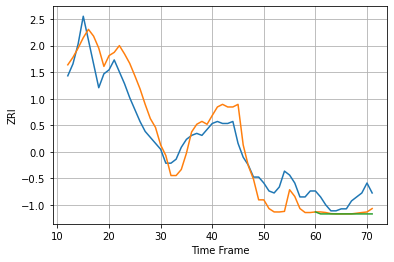

58103 10.008931815747207 7.5356109217963105 8.183581619177351


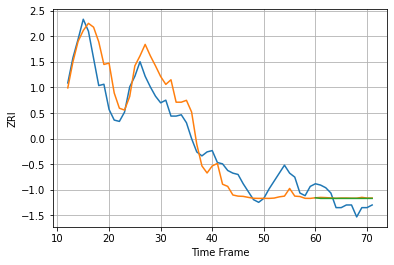

58104 14.93858712926259 7.959503200929778 7.938439594334247


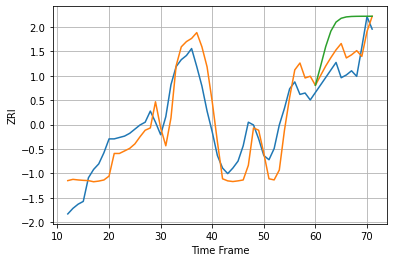

59601 16.59089317444319 12.166420136701962 28.696340784169784


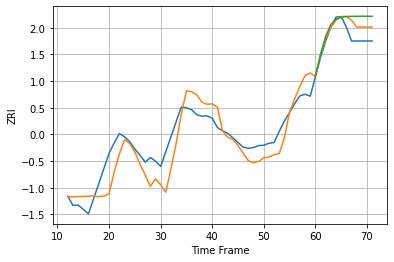

59718 44.7254547736224 27.39792419641691 42.369285565319885


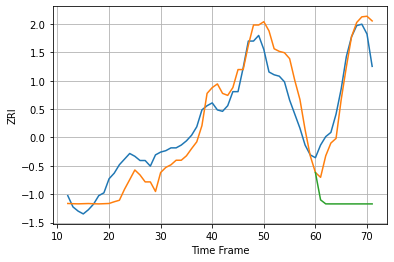

59801 14.640356817548467 14.518562541718309 90.85969936423415


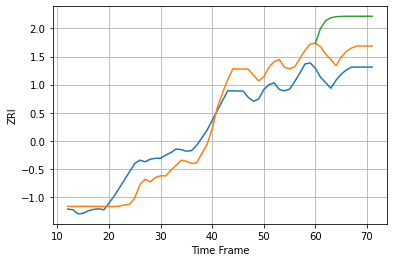

59901 55.28004542106503 70.97238554310645 168.95878232232175


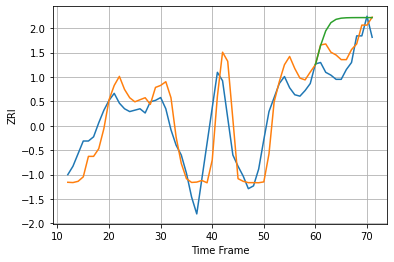

66061 16.52760527287038 12.266568804667981 27.50611798200408


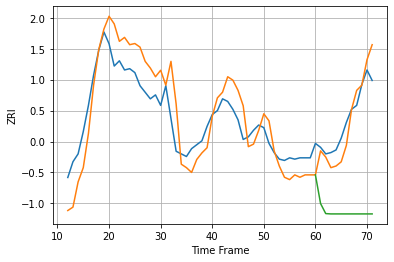

66213 19.1685345247329 14.264667970213779 72.25801237033656


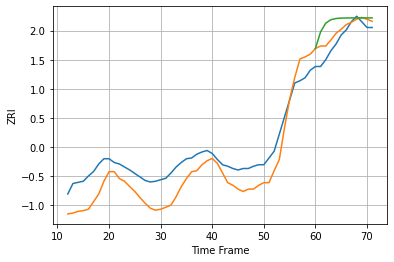

66214 28.332149777179154 14.171382473066744 27.525718382181022


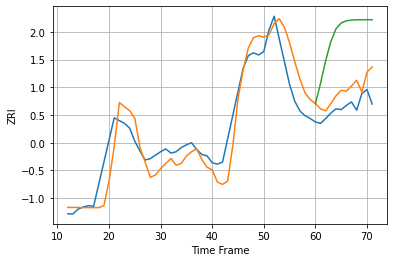

66215 29.473562855369188 27.299593089352527 105.54274585671729


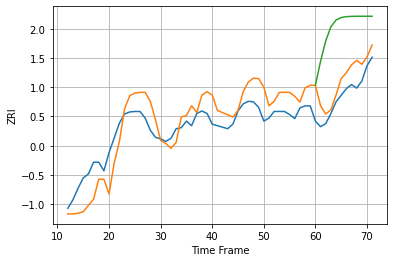

66223 39.33408051803838 36.2941884528357 134.6415056132656


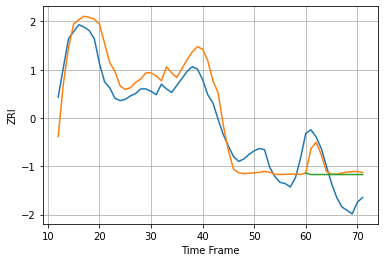

66502 16.06545471541877 22.962587771259965 26.5484008964454


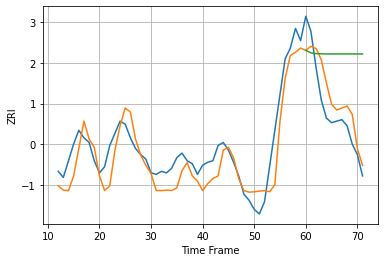

66614 12.86458586282928 15.465113321351174 46.4513479137191


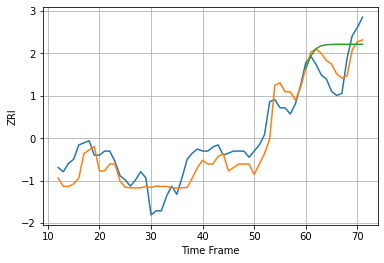

67218 8.293214277521376 8.620813995261864 14.59545866552868


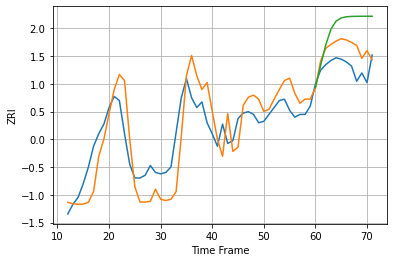

73071 18.420059598648674 14.64075577276102 31.17871689400843


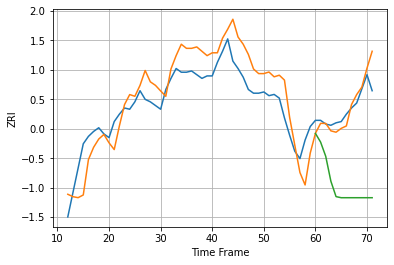

73159 18.707224948250275 10.897110411533827 65.5222374484905


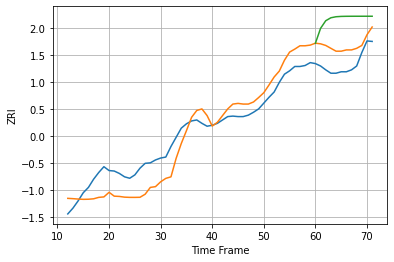

75001 36.76277636249238 40.266268060002865 93.89940839231184


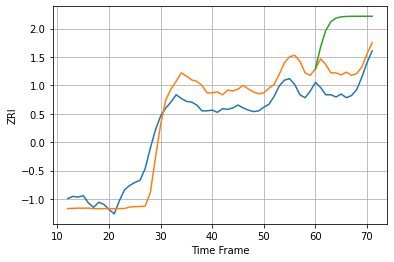

75010 26.91975349282685 27.709144198066134 87.25891713073094


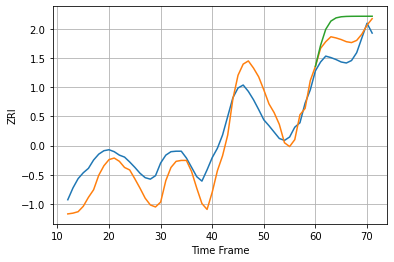

75013 43.196445148452455 32.09333687464694 65.54957238783315


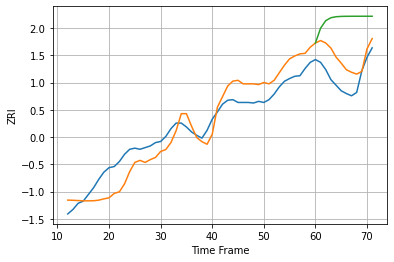

75024 29.829660581271252 38.82705146520277 105.6931088802916


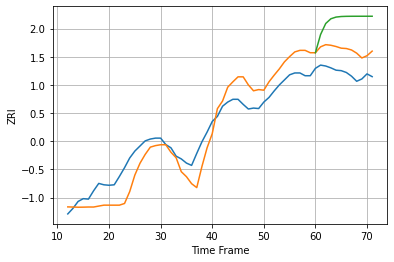

75039 39.92957498801647 48.72029621273578 113.51076676379279


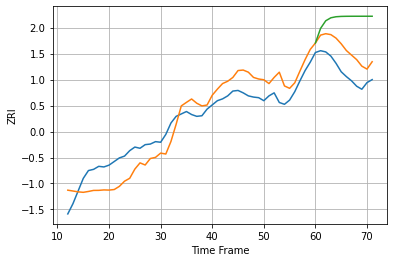

75050 29.755124643991294 35.95991744649608 89.30650614499895


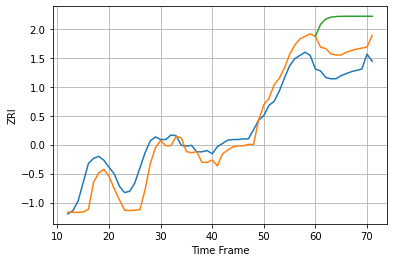

75052 25.69596375744188 36.249559424968126 81.51172638345582


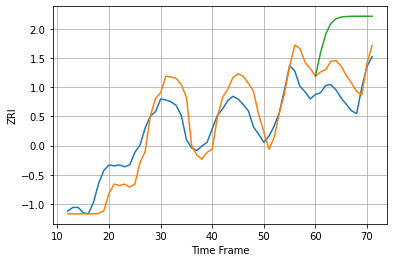

75056 23.357106820711017 24.151533012209832 75.14477013482713


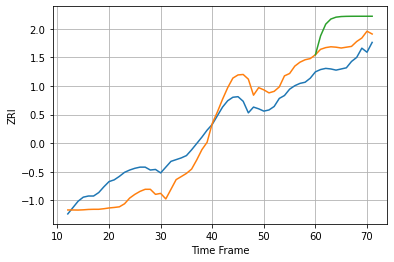

75063 34.90213248557932 32.04655608706748 72.10841349483402


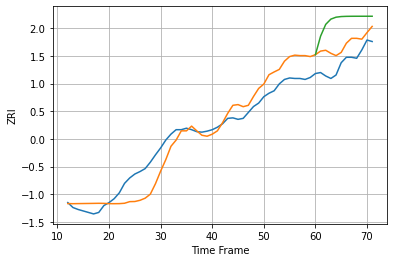

75067 31.9589788263862 36.80798635106386 84.5162699279128


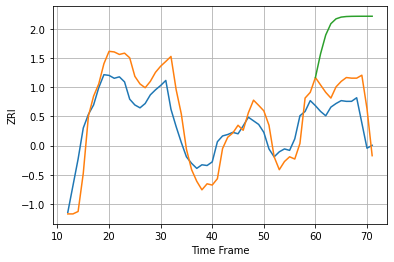

75070 31.746028950025 36.27143978934903 125.55026633573067


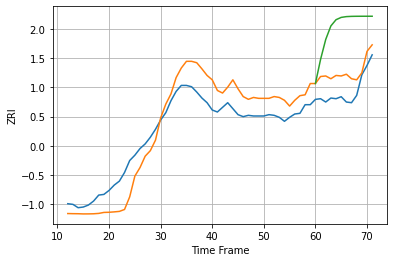

75074 30.004752751723974 29.648198117943792 98.85986691384417


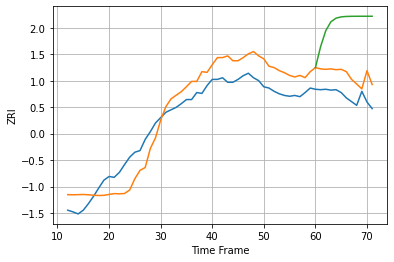

75081 46.783614890362514 53.89548602947915 178.38941073497782


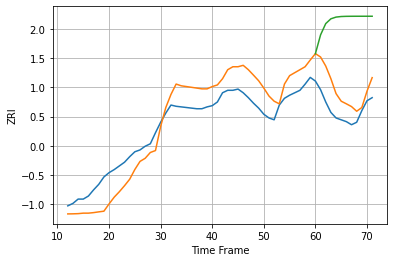

75093 33.05840261567239 37.74871886068487 145.72809561341373


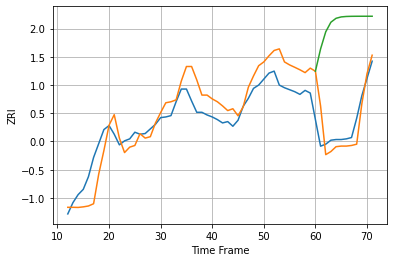

75201 28.747452575221814 31.3461204647533 150.775553885411


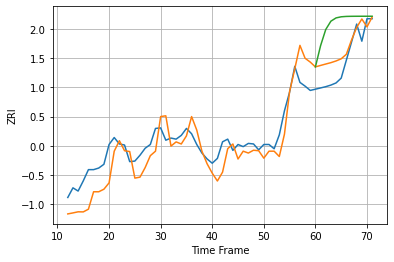

75202 34.96625848432595 31.849054936755092 77.95465409327412


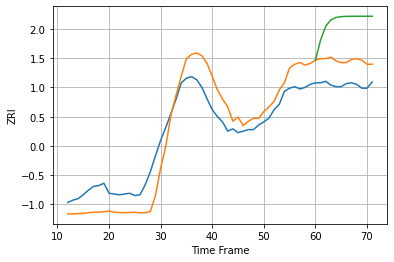

75204 27.604228538396097 31.394396947133284 82.10379229604354


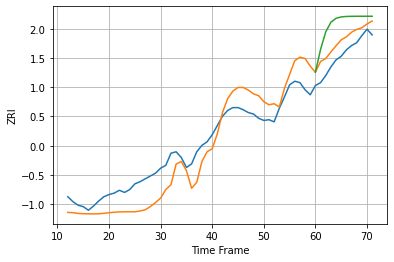

75206 27.854796195701475 19.895509919225628 44.41327286973428


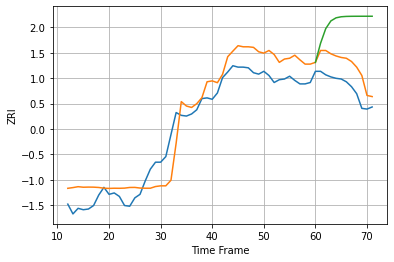

75214 27.601766306944302 31.651631419114892 96.17561889632806


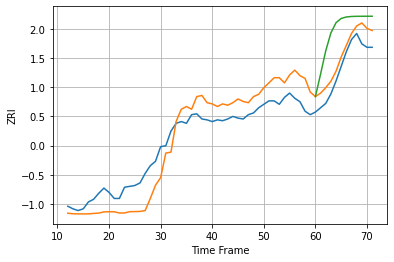

75219 22.989738732931002 15.872215229901848 45.18085622535364


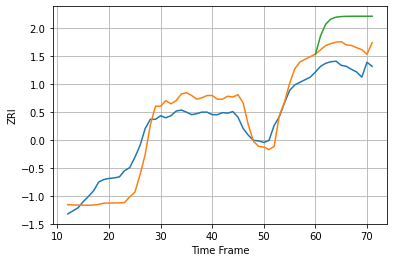

75235 34.64511815660359 40.34511904685438 90.0023340057571


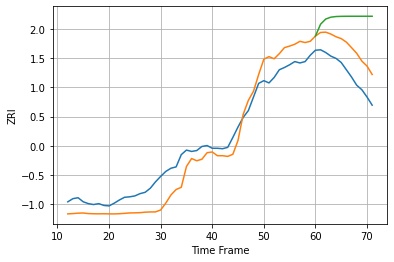

75243 37.985719976868744 56.20163740441955 124.83639983857448


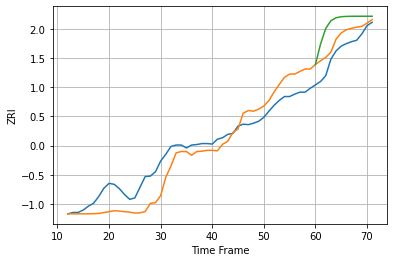

75244 35.18398449341291 27.604401197971736 59.1864294042461


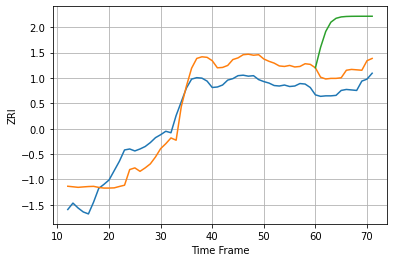

75248 40.051749368372164 37.244998492780084 133.43295709204634


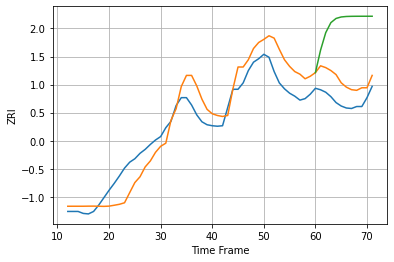

75287 38.706165224289194 41.63880670493074 155.6536070135423


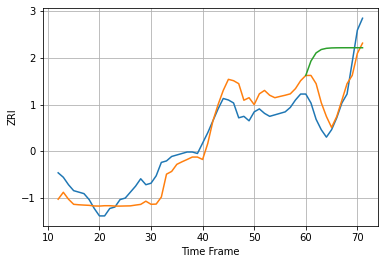

75703 10.849850449688589 13.721807975697033 38.359247334081935


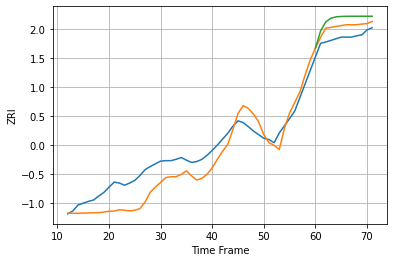

76006 38.68336416248134 24.013579434053945 40.542348952487


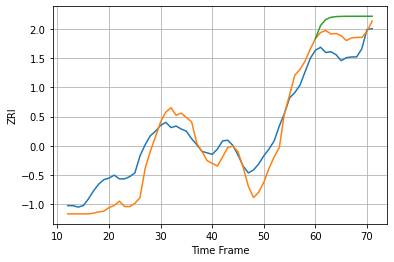

76010 25.022140988382443 22.800559893841186 43.75646806656049


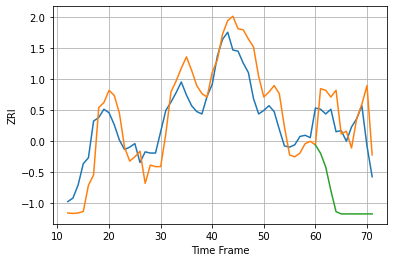

76012 20.627500606851452 22.976526992797094 62.4754785241374


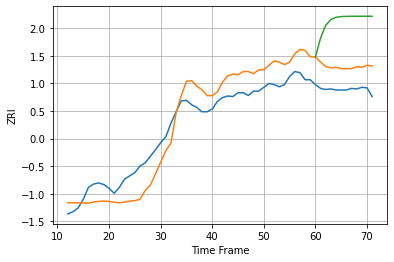

76015 36.09170602687304 43.16251450082257 125.11417868249103


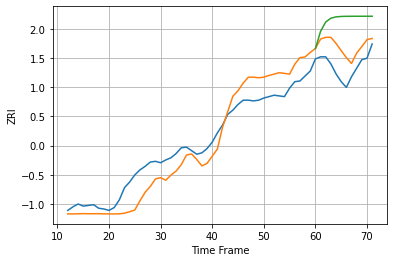

76017 24.764379852302728 29.383925454024283 67.18764213748015


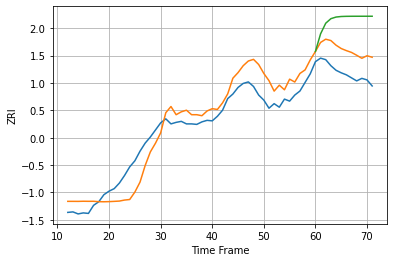

76039 33.27099512243209 45.386067484217676 105.86811334127906


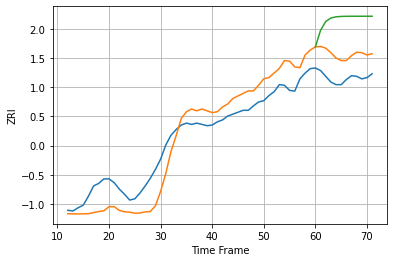

76051 30.70641677845977 37.44599047004374 90.6820150040513


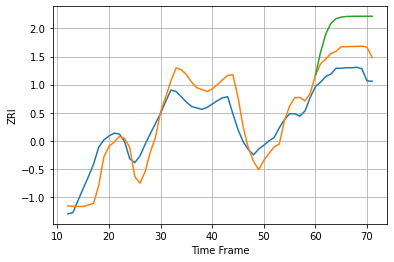

76107 38.864662158280325 44.17669422109955 102.49164387222535


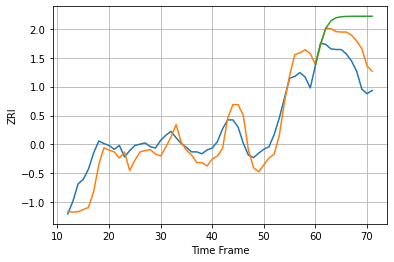

76108 26.684355349795243 35.378813784568244 73.30563693709115


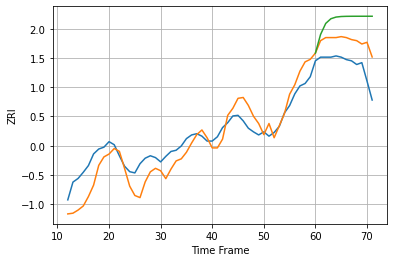

76116 27.480483337746108 39.605860905839734 75.86749576008324


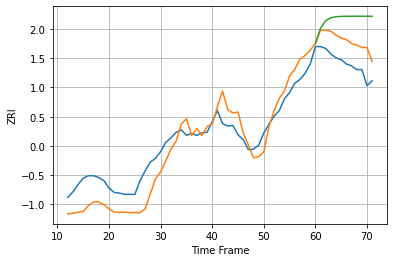

76132 30.382782704257092 36.41717256392978 74.14076923487677


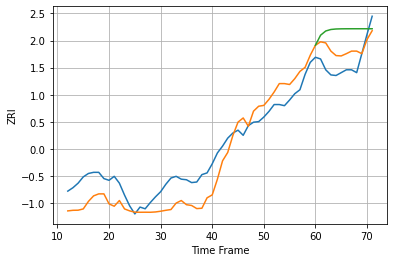

76133 34.8608503670123 30.871510619075497 60.92855483245906


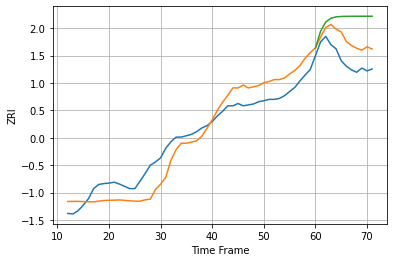

76137 35.82789982854321 43.78679761435897 91.0099633041391


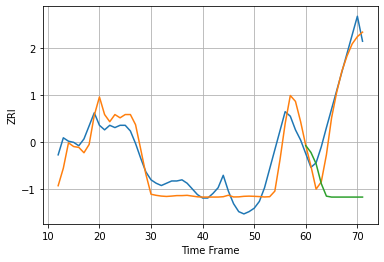

76522 14.361841348959953 14.798299157426866 96.79142376165724


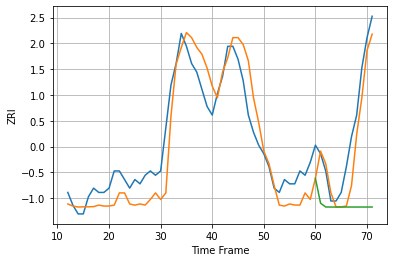

76543 5.71671249997359 5.689770821541275 21.7280306604697


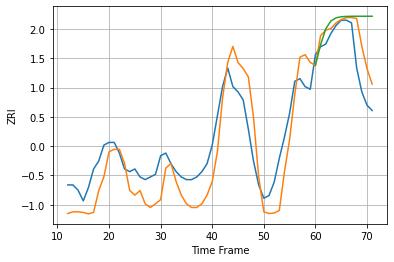

76549 10.393644969791925 9.12646825916345 17.462543301688545


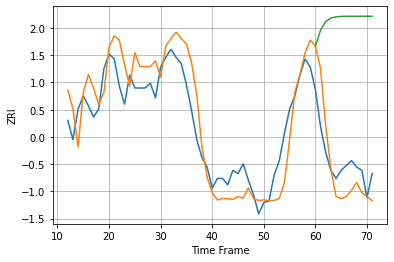

77004 15.94011423906954 18.26518710633761 89.169841901309


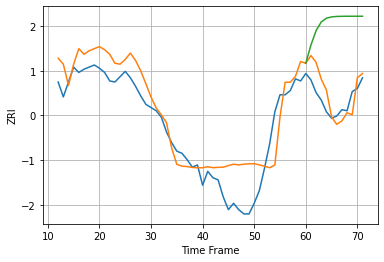

77006 22.272664725955416 15.819682481884726 73.08341701876138


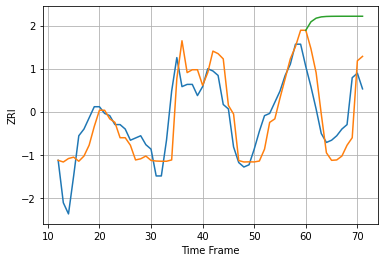

77007 10.277250125242345 13.871567350252995 42.79904988421097


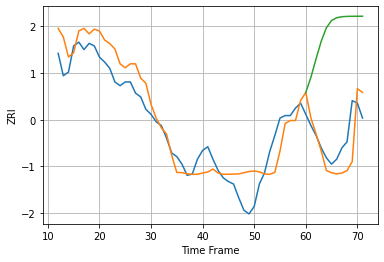

77019 16.236550745440763 19.46161610328303 85.41293483108592


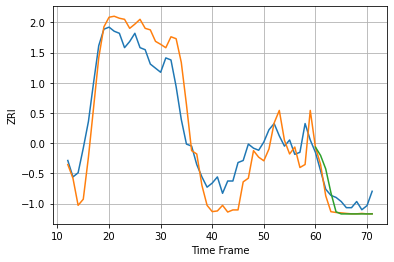

77027 12.552092168808542 5.521908847131179 6.089895228102053


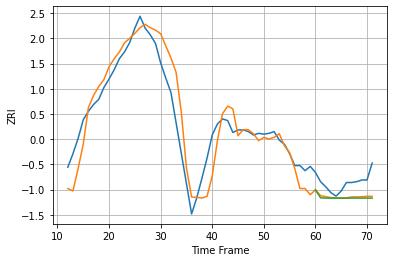

77042 23.343203263251358 18.64167759748004 19.887605193389504


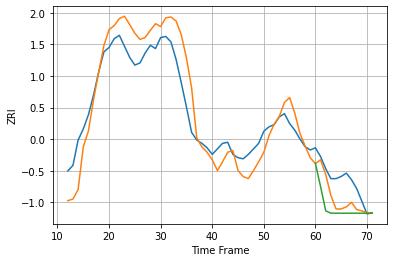

77054 20.41976143259502 18.021262724614367 26.364276452716197


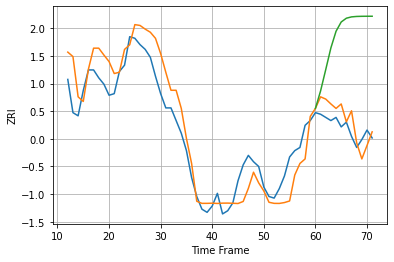

77056 14.484749576360743 9.771577525757252 60.98785278959434


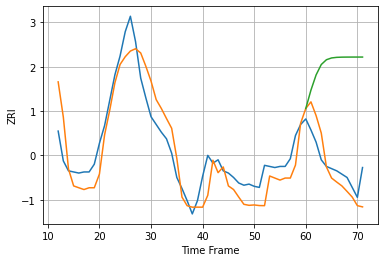

77057 19.744904183682053 17.686200856536743 93.84185079740583


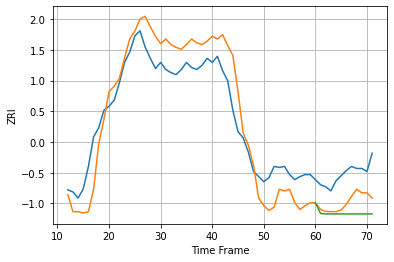

77063 25.540827509617543 28.099584884146985 38.97724071822791


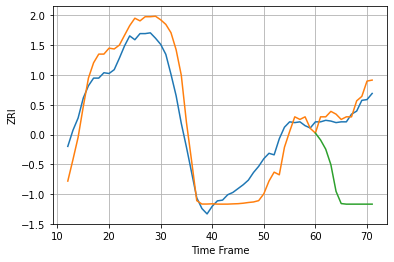

77077 28.503401710326482 11.950275582166832 101.01266114648516


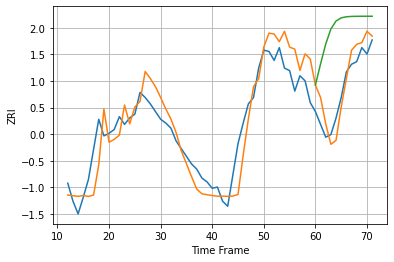

77090 16.999805097121172 13.116572381616571 50.59934007256446


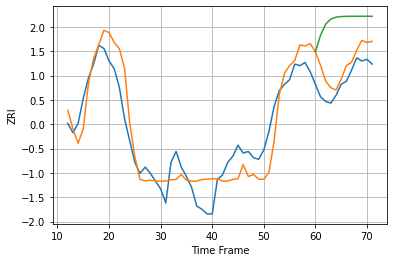

77098 13.984804898319243 12.176444091453794 38.63743545953762


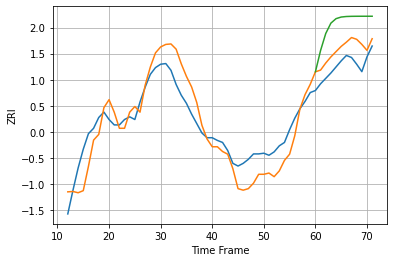

77380 28.774559185906462 25.36250070207082 62.51732442807085


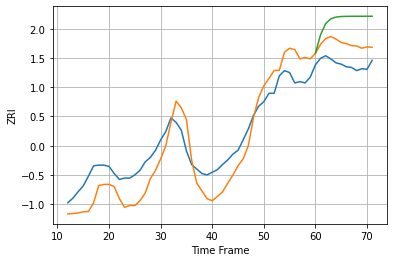

77429 34.13667785445637 31.108163553672657 68.1128605372285


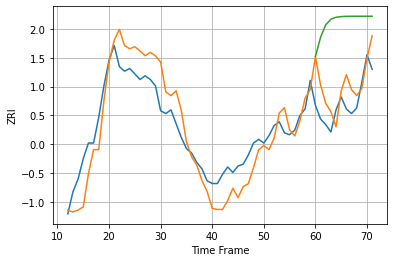

77494 25.032403891582653 27.70473624805882 89.71199639016365


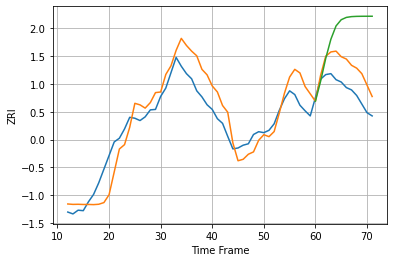

77550 40.9437225002044 50.18979554015662 141.36976331113226


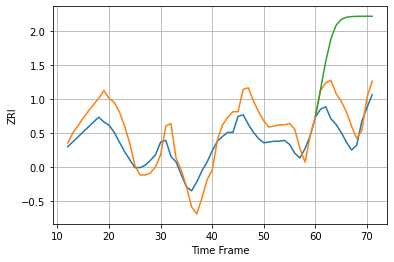

77584 23.964645758647787 28.482811383008915 117.89044110397862


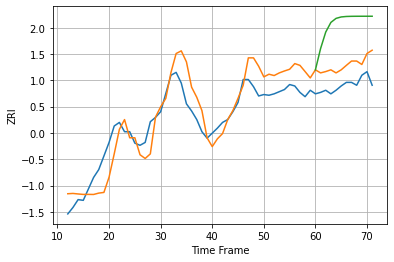

77598 27.017690241609483 29.804219427055298 86.31803011581752


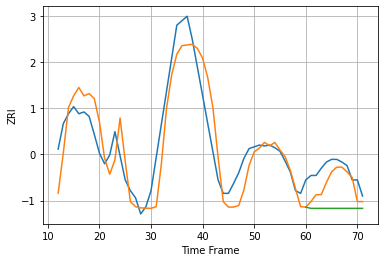

77840 26.433593877911086 19.600986636965317 42.32574019107178


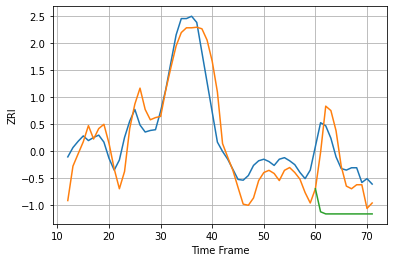

77845 26.85542809239084 30.530415090491758 72.26234494371754


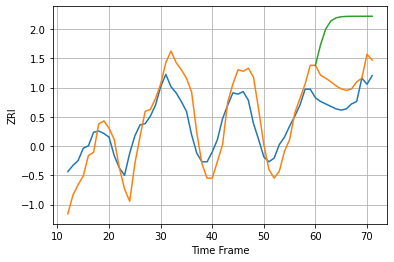

78130 18.555863589952224 18.291096124756677 61.90615287544557


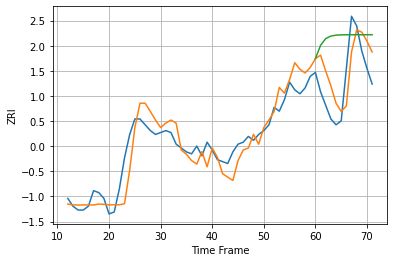

78201 7.930063674797868 14.270369558125239 27.677606963767264


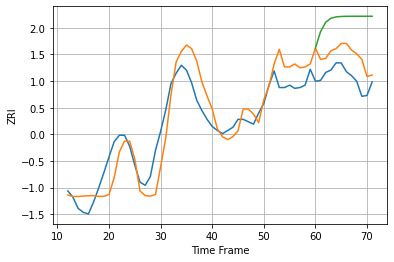

78209 24.9547772091501 29.676582923527118 73.34821509126414


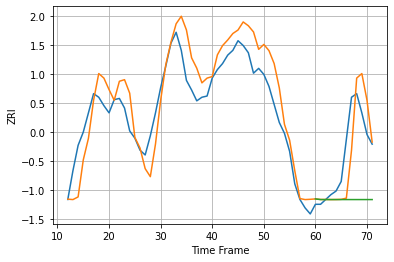

78210 20.422682044283043 23.633315493547858 48.36535131850149


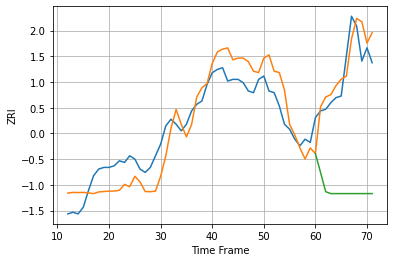

78212 12.721719918655191 12.764916552872611 72.32933608728717


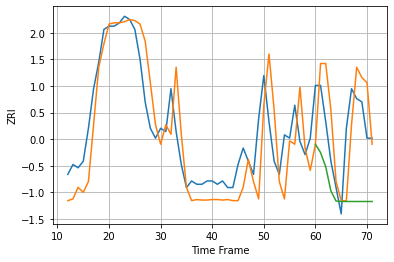

78213 9.99346065816689 12.827239914063483 21.073210726139617


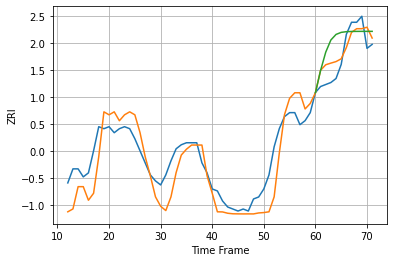

78216 10.40423271233685 6.906553334236808 11.980476968764483


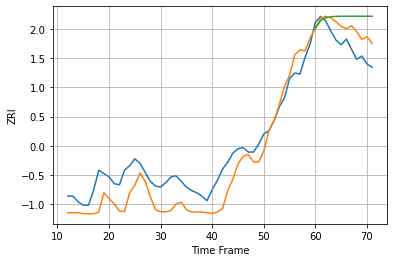

78229 18.708961723054163 15.992025133643962 27.491741406605872


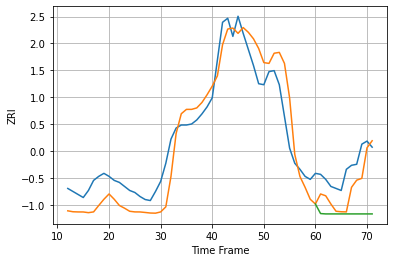

78233 22.541978698544558 23.43309658238969 47.15411762380888


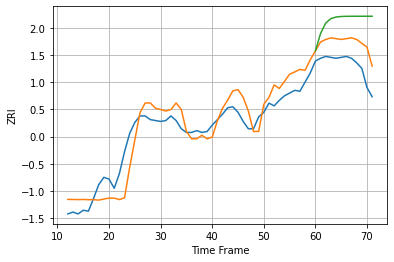

78240 17.60414862638089 24.867907851569644 51.36548435735627


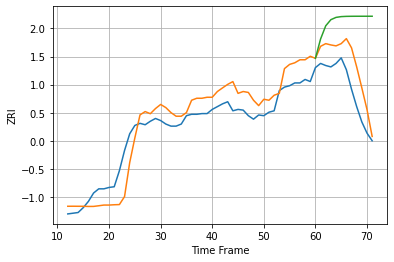

78249 25.231923844181697 36.6840836456798 105.61287833926903


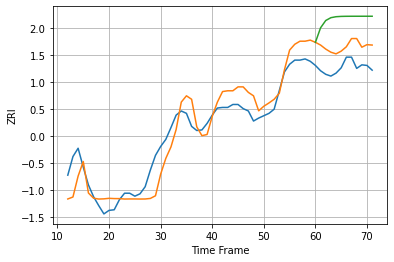

78256 28.623237171276028 37.066170125981785 82.0326829596019


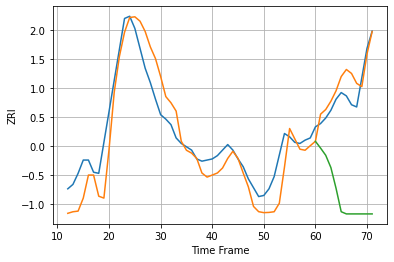

78521 21.13536828115426 14.58684230606665 99.12411175929485


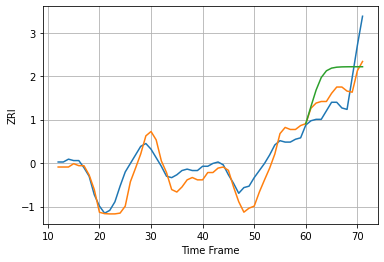

78550 9.381861879601004 14.09782543730853 23.528605811079363


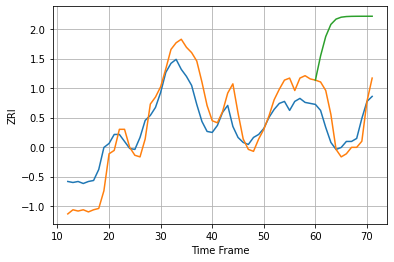

78613 22.393501653498493 19.894871075600555 103.9880466525074


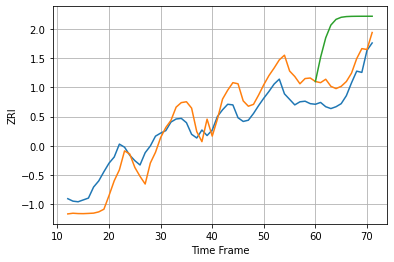

78660 31.971654025133482 29.449600516200555 103.23063867229513


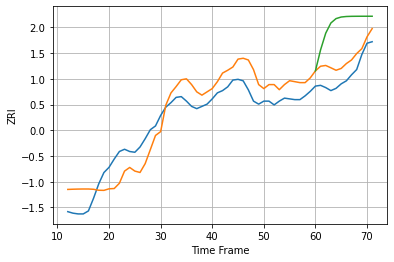

78664 25.26564326771758 21.690317495232645 68.23929141503918


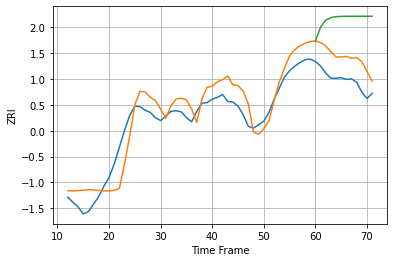

78666 28.425715256105427 40.654089019496205 107.60578428257355


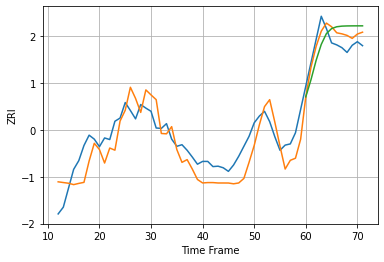

78701 48.50235827230426 29.13703355564464 48.008023448341945


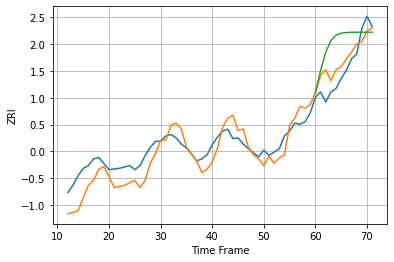

78702 22.487914078579646 21.861258198739453 49.46062004604625


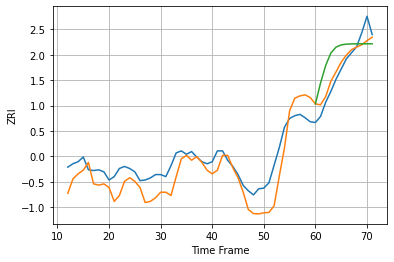

78703 26.683907025413546 16.486144724231306 36.163462515150066


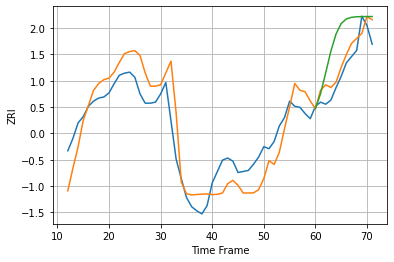

78704 22.23848934305653 12.938603254140121 33.68024566622227


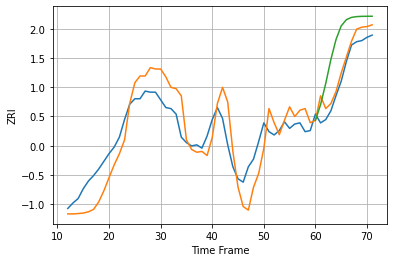

78705 20.479769508931305 10.602461485791784 32.26801246223192


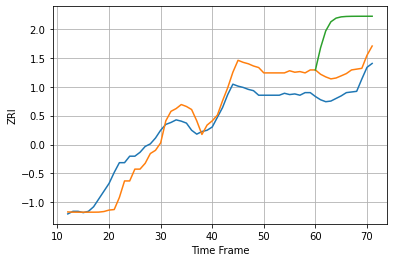

78728 28.12607806136374 32.057709984320425 102.78905852640483


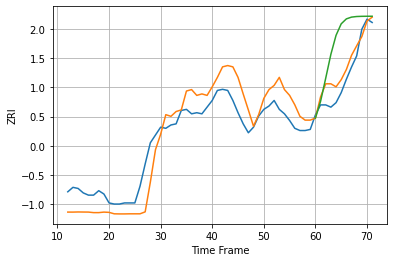

78729 18.37800822359062 11.31361755479588 37.302171434775616


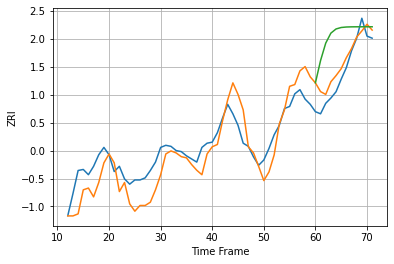

78735 19.100511644732205 13.774424744249275 39.60982714770485


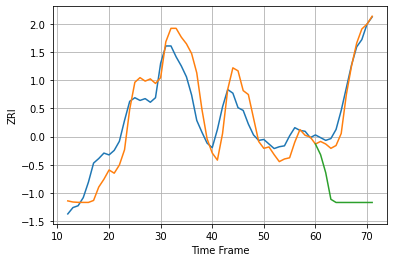

78741 23.49247529159751 10.877108070351044 130.3027172941038


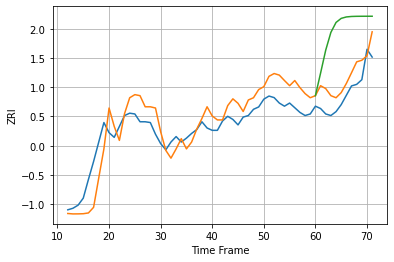

78744 24.265869092929147 23.09445207149036 82.9411773782966


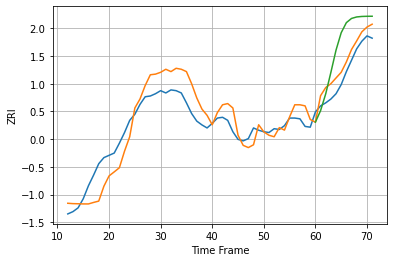

78745 22.50229281049404 15.705196110526698 41.8468042074897


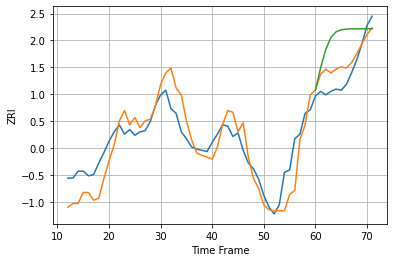

78746 17.42806295088473 13.457246640776626 34.28850163784808


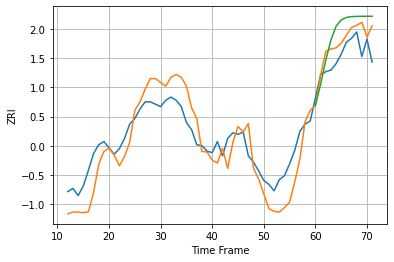

78748 27.441392146045164 22.983167740475775 35.093480688417586


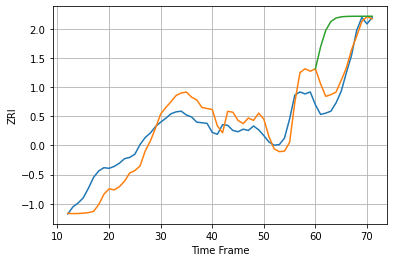

78749 26.98994800873251 25.36743437615797 88.15785032617761


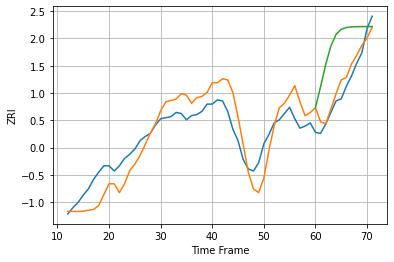

78750 18.6604111046448 11.413211062560128 46.186955798418325


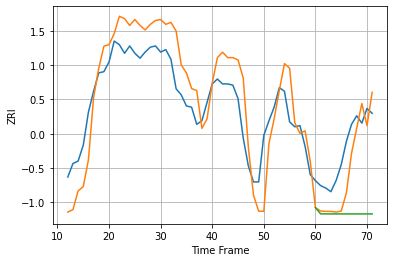

78751 25.20304030676006 23.816049731605982 57.051474778435555


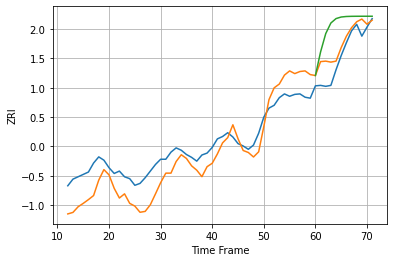

78752 42.73395462460208 29.524285513990776 70.79318943678227


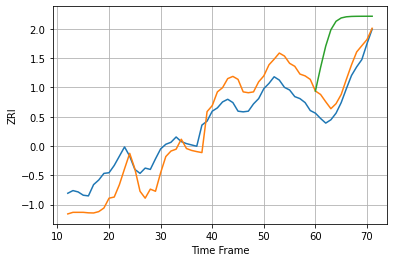

78753 32.798788001898 21.51774547401223 94.29991352735334


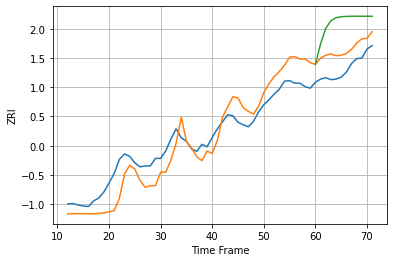

78754 36.27207257156668 38.33753877316888 92.33506320947342


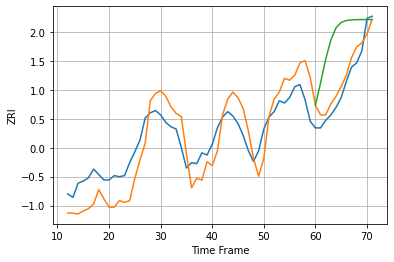

78757 21.796696418703554 11.221471646203737 48.139330766635105


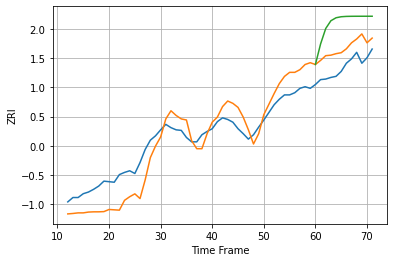

78758 34.598262912923786 35.57149530882637 82.235058089007


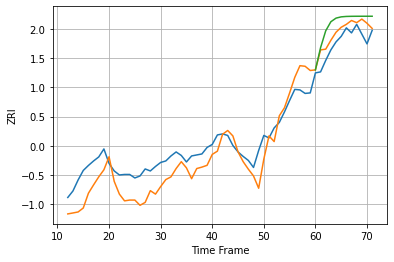

78759 39.43982011499334 23.868539892754114 40.649191788537735


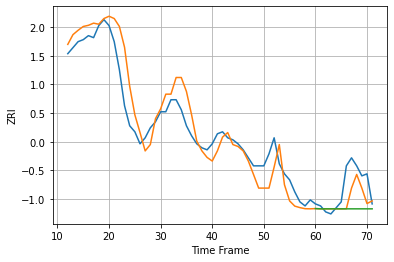

79912 9.62472551229965 9.09595914831752 13.479477909767665


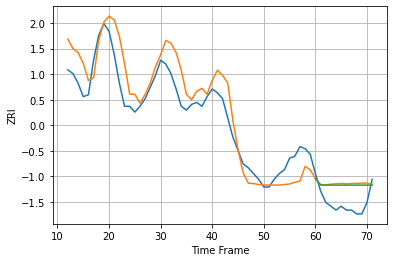

79936 11.036592060544884 11.377159297680356 10.741313714894591


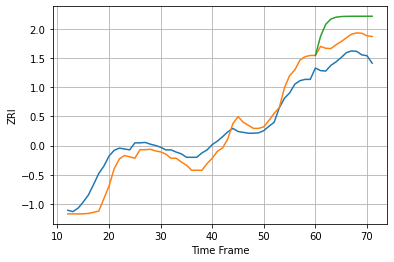

80021 32.79895359832589 44.28064498831956 89.33055420789499


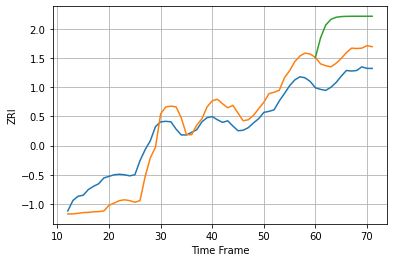

80027 37.28997902119986 42.486126010338644 106.18745489183114


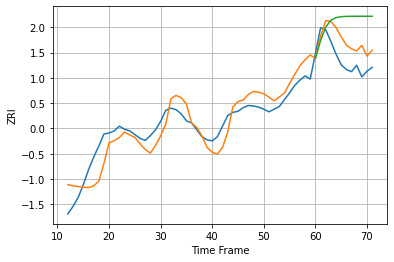

80033 28.339216589412622 38.25117793873227 80.77275905290992


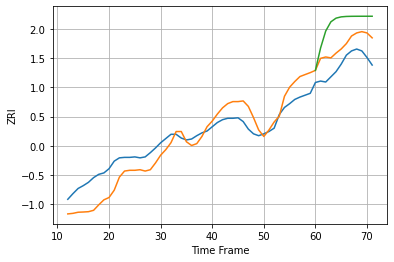

80111 35.86568436545599 41.34693451224487 88.85230712807117


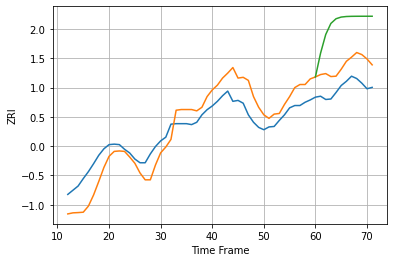

80112 40.68219847925912 48.97035035925454 136.99736631320715


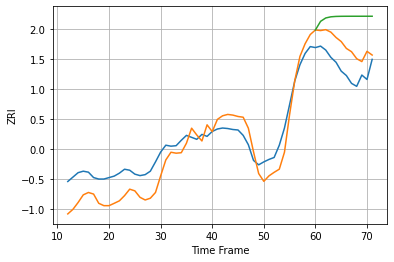

80120 38.72509798215882 47.764763163682574 103.53137288715573


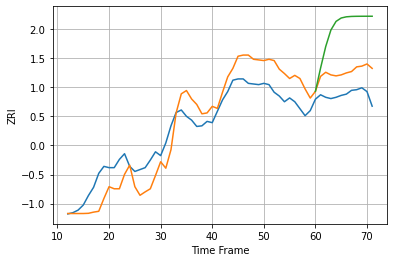

80124 33.85756207756428 36.58594738308463 107.31598485301153


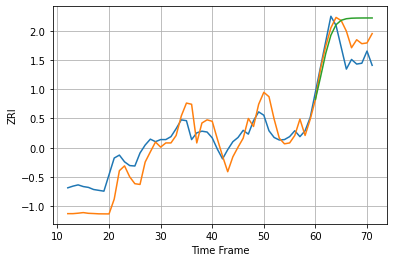

80129 44.41641835296946 46.75738184489316 78.85149419749227


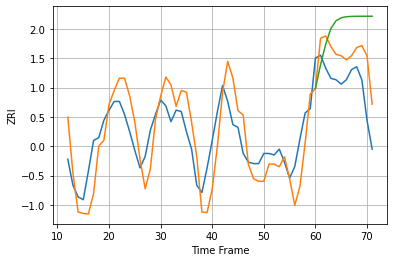

80202 19.515364794035367 22.788695340367518 46.346155051243514


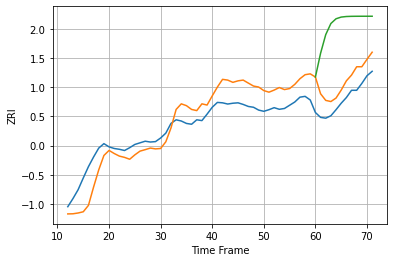

80203 44.69423525118422 48.569092774224686 182.321348921245


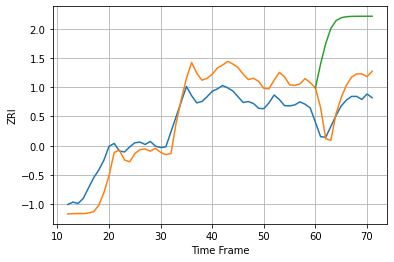

80204 60.58969104012422 60.1301630559645 240.98119820646065


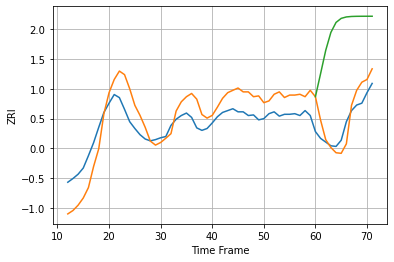

80205 32.837634764105005 26.98599708754553 149.66061823525513


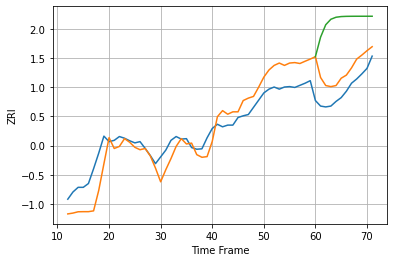

80210 42.08988565618798 52.188675784759255 161.78714769320985


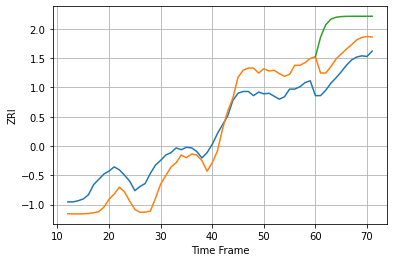

80211 35.11018328193594 34.356927389785376 84.78144638536475


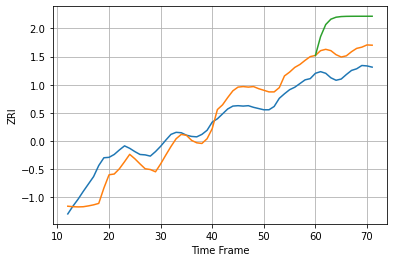

80214 40.00381557944129 52.62920612148321 125.5666775438033


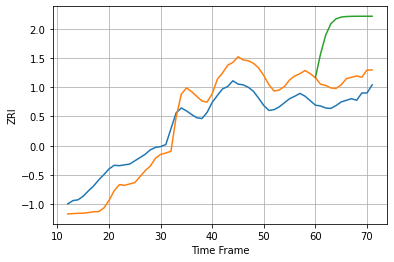

80218 51.751677309314196 51.56475833990147 185.42464514570173


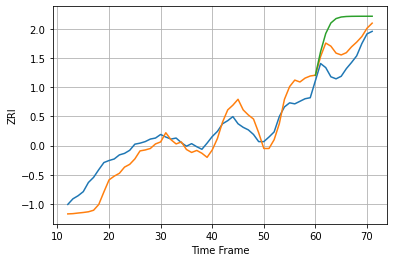

80226 30.611286543334742 33.781733336131715 78.09891129843058


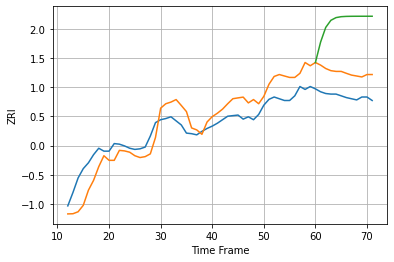

80229 29.635487572607108 41.45749430654903 127.00017485543543


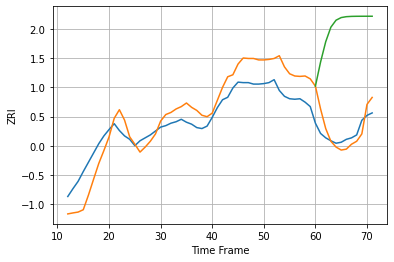

80231 40.52923625896478 31.58745022989175 215.5538775702092


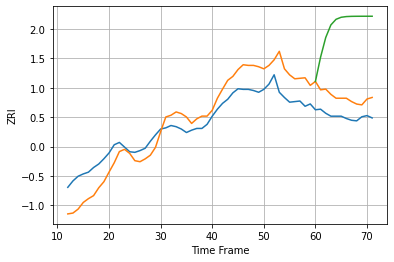

80233 34.29369119143451 34.16797001415307 155.89922335217904


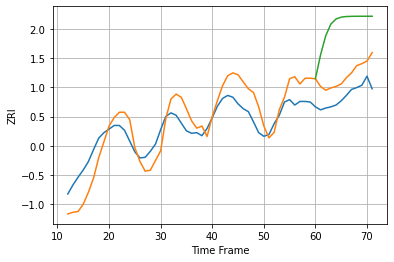

80237 32.093208407440436 36.31986583935258 118.24876788971243


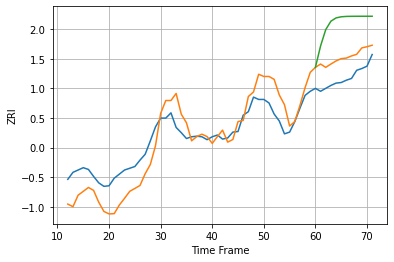

80301 34.26079143702349 35.97954109457115 94.14636204499146


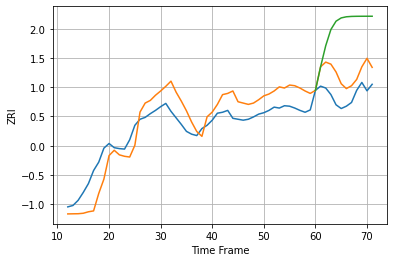

80401 39.80942557927119 47.80273192599432 147.94019701231514


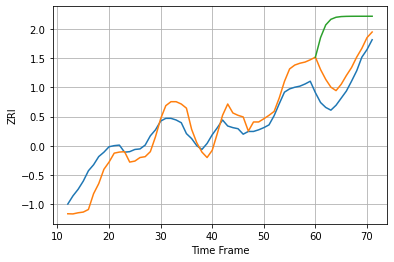

80503 29.87503465380392 37.26798409532658 119.4935798141384


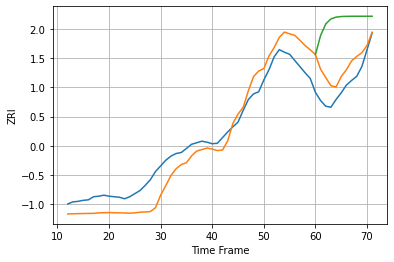

80904 34.323914969838924 41.04871282910042 124.58064761190671


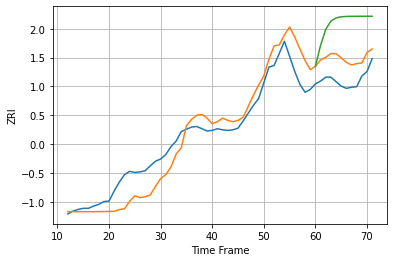

80915 31.80482357193951 38.596252734790376 102.3638908812425


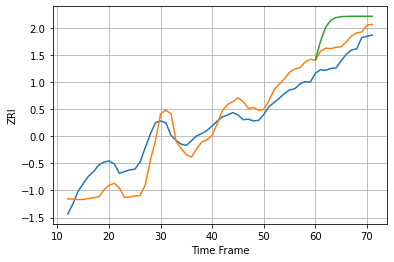

84047 30.274504408392453 26.059176589098453 58.332738309471765


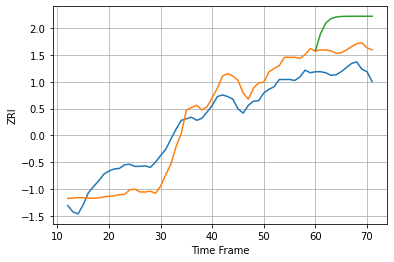

84095 38.06798405870788 43.4029947445244 98.36413801732307


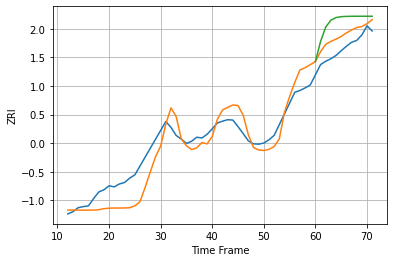

84102 44.2259198909664 36.2555766582011 74.03052443553418


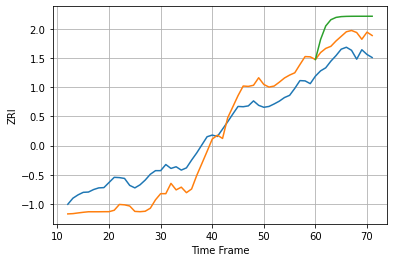

84103 77.63103929758303 65.89776161610129 129.24452450771315


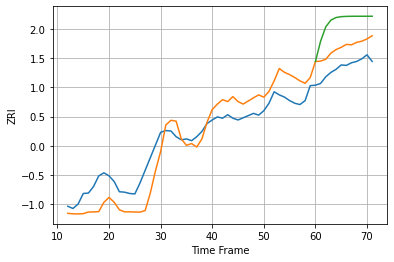

84106 44.025783238669185 45.36373675923956 102.67550863844376


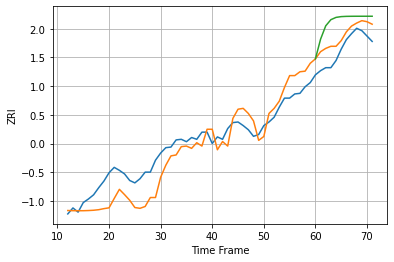

84119 30.033024613659954 24.03003047150824 49.42628418529008


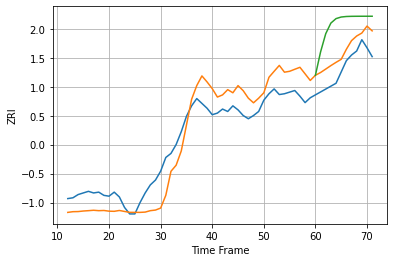

84403 24.840956390418928 22.416315615113025 55.5208067088993


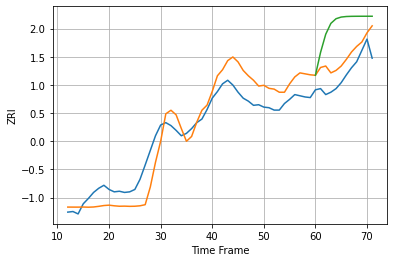

85008 31.282957966498444 31.84954104698262 84.72146247833781


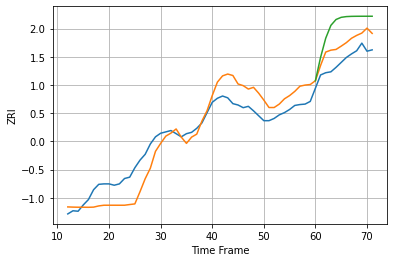

85014 39.31063265577478 36.61896119062388 79.87489885698085


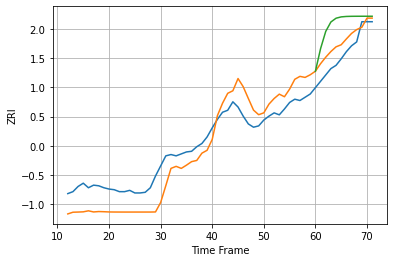

85015 31.258367293073803 21.035819925241203 49.062457246272416


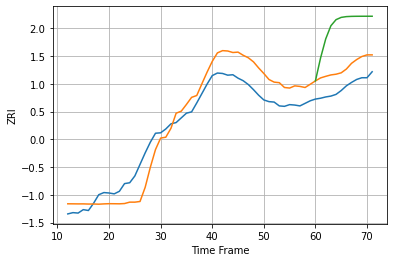

85016 43.39216238291413 46.04741753416187 143.43764947233217


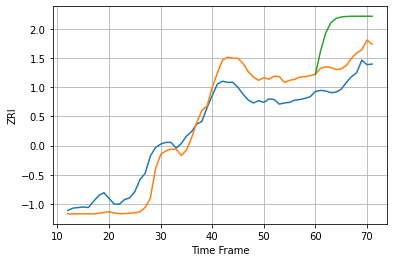

85018 33.91997889775341 35.86894063018648 99.07013626784881


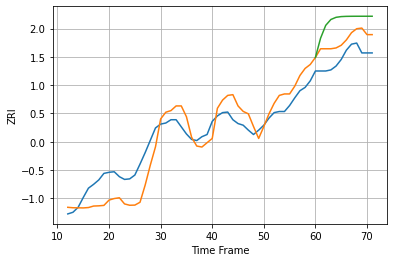

85020 33.13522370979145 32.83458466163665 68.27905953742994


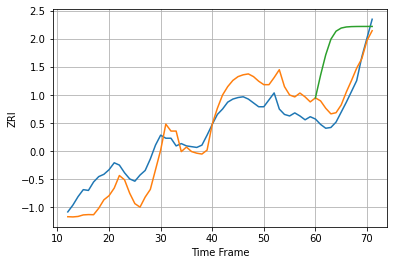

85027 26.621823379845033 17.824433777189935 80.01737725665572


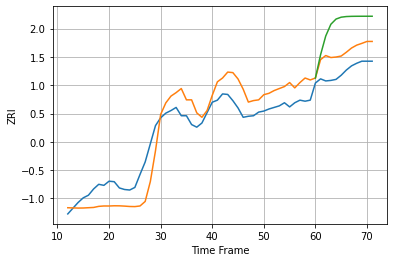

85032 37.87422458430315 37.25909417058708 90.25623498209309


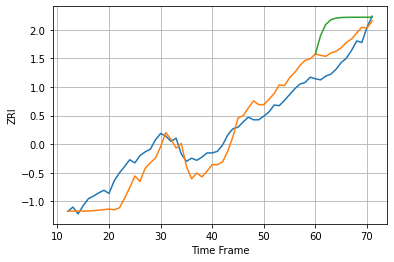

85044 31.378374549477527 31.533416409124616 71.47138868778823


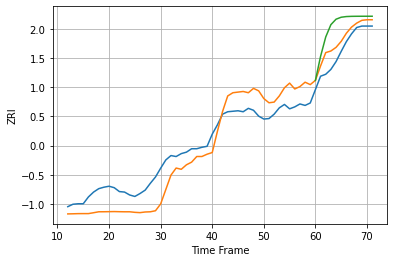

85201 39.198998757389795 23.332160046076837 53.6498566255394


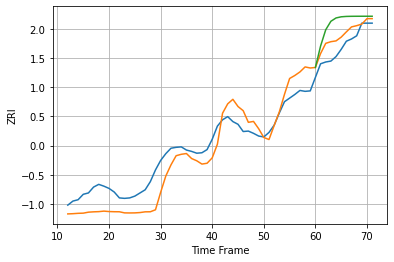

85204 39.65926699826891 26.34450915621011 54.38813942206475


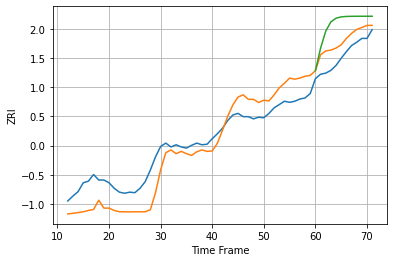

85224 35.65768581222573 26.806497623814963 59.0988683079407


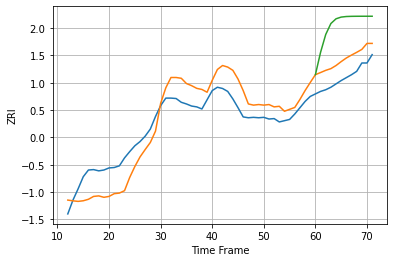

85251 46.32963569460535 43.52713112742594 125.99884750352179


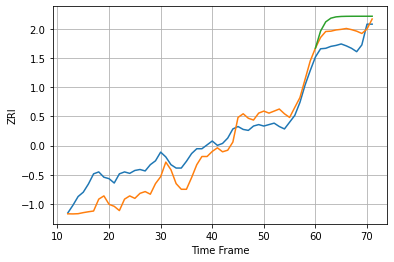

85260 38.481929202118586 29.450931900340976 51.99591991951093


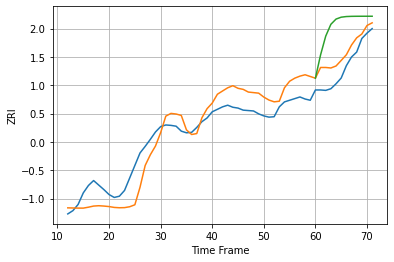

85281 42.42376027483222 37.1182352372638 105.47041384058782


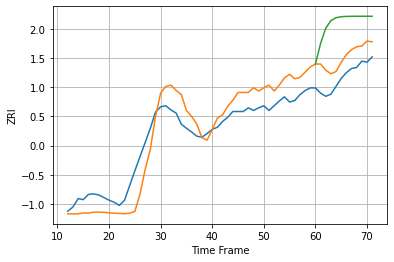

85282 35.60594670490964 38.93175574464595 104.21406044190344


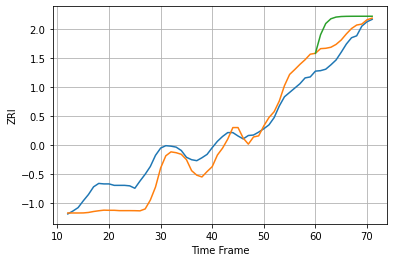

85283 36.66771766391058 28.311856252479203 61.65846678495506


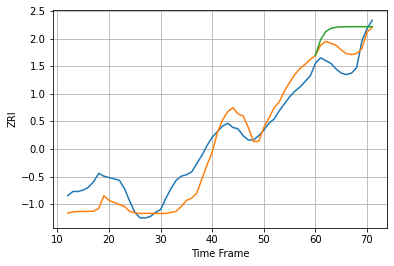

85705 13.118806653984162 11.714371556765478 23.381325957334685


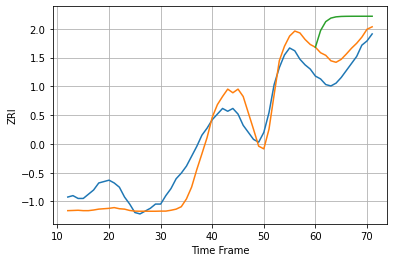

85716 13.339717474859498 14.078062799118754 34.59857878668678


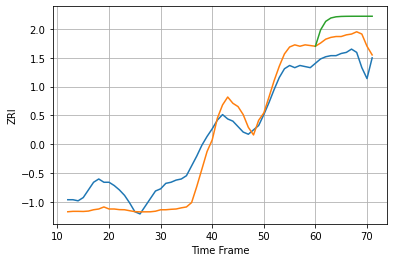

85719 17.69277149913665 18.665626668209164 36.10145627005678


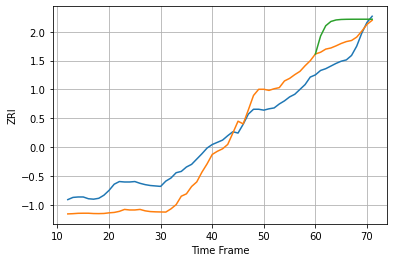

86314 46.67120078262068 34.44791714090195 74.60823271687721


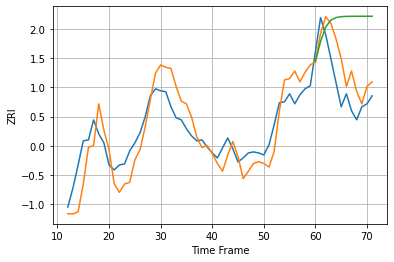

87111 20.919042966426975 27.49159677287331 71.97254314469525


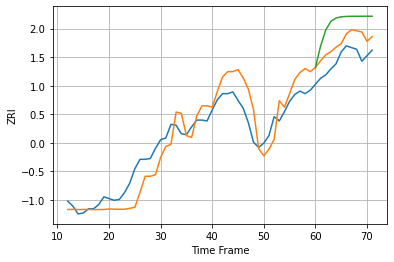

89030 21.08240936049145 20.51137941839476 43.58435251772842


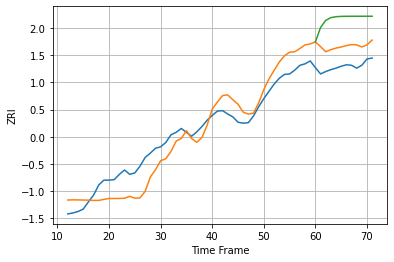

89052 34.24127377733863 43.03245572903541 97.75276351167244


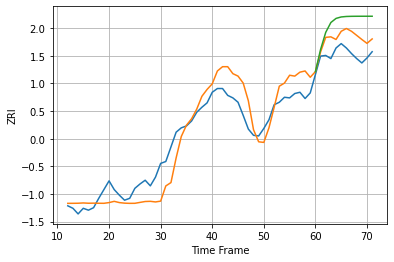

89101 28.50637828212287 26.952685564180793 52.40477210021192


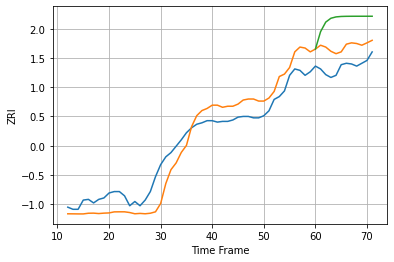

89108 23.924229184069382 28.85577361946418 65.763187961489


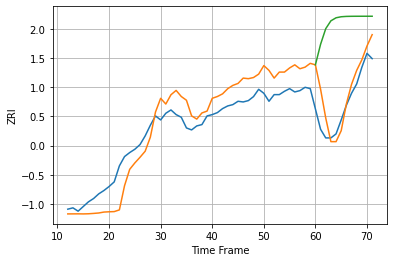

89117 29.5124424133185 30.932333260420428 124.95995361315275


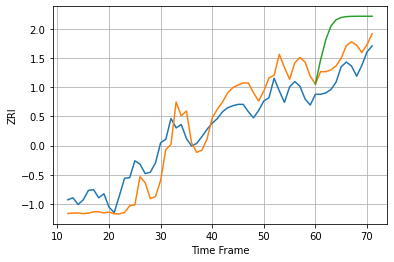

89119 32.051379048270654 27.10002268102274 70.75144435361673


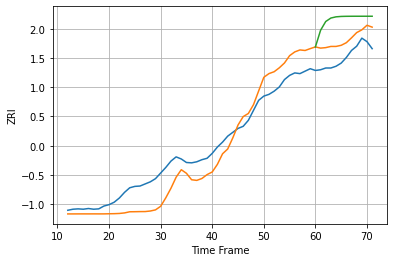

89502 51.15655516957378 51.82413644207125 108.17593986914302


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_5:
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis, np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]),
      sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

183 28.559465328170283 79.02091559422944


In [16]:
test = pd.DataFrame(score_dict)
test.to_csv('NN_5_batch.csv', index = False)

In [17]:
# NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [18]:
# NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [19]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')